DEC 알고리즘을 대전시 자료를 활용할 수 있도록 수정한 파일
입력자료: 44개 검지기, 1일 16시간, 10분간격, 5주간 입력 자료, 교통량과 속도자료 

In [1]:
from keras.datasets import mnist
import numpy as np
np.random.seed(10)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 80% !important; }</style>"))

Using TensorFlow backend.


In [2]:
from time import time
import numpy as np
import tensorflow as tf
import keras
#import tensorflow.keras.backend as K
from keras.engine.topology import Layer, InputSpec
from keras.layers import Dense, Input
from keras.models import Model
from keras.optimizers import SGD
from keras import callbacks
from keras.initializers import VarianceScaling
from sklearn.cluster import KMeans
import pandas as pd
import metrics
import warnings
from keras import backend as K

In [3]:
print(keras.__version__)
import warnings
warnings.filterwarnings( 'ignore' )


tf.test.is_gpu_available(
    cuda_only=False,
    min_cuda_compute_capability=None
)

2.0.5


True

In [4]:
def autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected auto-encoder model, symmetric.
    Arguments:
        dims: list of number of units in each layer of encoder. dims[0] is input dim, dims[-1] is units in hidden layer.
            The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
        act: activation, not applied to Input, Hidden and Output layers
    return:
        (ae_model, encoder_model), Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    # input
    input_img = Input(shape=(dims[0],), name='input')
    x = input_img
    # internal layers in encoder
    for i in range(n_stacks-1):
        x = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x)

    # hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)
    
    # hidden layer, features are extracted from here

    x = encoded
    # internal layers in decoder
    for i in range(n_stacks-1, 0, -1):
        x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)

    # output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    decoded = x
    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')

In [5]:
## 입력자료를 확인하고 input format 수정

trains = np.loadtxt("C:/Users/KOTI/project/AI_traffic_management/Deep Clustering/DenseLayer/data/test_speedflow8_normalized.csv",
                    skiprows=1, delimiter=',', dtype=float)

x = trains[:, 3:531].reshape([len(trains), 528])  # 열의 갯수를 수정
#x2 = trains[:, 531:795].reshape([len(trains), 264])
#x = np.concatenate((x1, x2), axis=1)

print(x.shape)

y_year = trains[:, 0].reshape([len(trains)])
y_weekday = trains[:, 1].reshape([len(trains)])
y = trains[:, 2].reshape([len(trains)])

x = x.reshape((x.shape[0], -1))
#x = np.divide(x, 256.)        #normalized 데이터에서는 삭제


(3360, 528)


In [6]:
n_clusters = 7 #len(np.unique(y))  # cluster의 갯수를 직접 선언해야 함
x.shape
print ([y_year, y_weekday, y])

[array([20190818., 20190818., 20190818., ..., 20190921., 20190921.,
       20190921.]), array([1., 1., 1., ..., 7., 7., 7.]), array([ 600.,  610.,  620., ..., 2130., 2140., 2150.])]


In [7]:
#kmeans = KMeans(n_clusters=n_clusters, n_init=20, n_jobs=4)
#y_pred_kmeans = kmeans.fit_predict(x)

In [8]:
#metrics.acc(y, y_pred_kmeans)  # 우리 자료에는 label이 없으므로 accuracy를 구할 수 없음

In [9]:
#dims = [x.shape[-1], 500, 500, 2000, 10]
dims = [x.shape[-1], 500, 1000, 2000, 3000, 5000, 10]   # hidden layer를 어떻게 구성할 것인지 고민 
init = VarianceScaling(scale=1. / 3., mode='fan_in',
                           distribution='uniform')
pretrain_optimizer = SGD(lr=0.1, momentum=0.9)
pretrain_epochs = 1000
batch_size = 128
save_dir = './results'

In [10]:
autoencoder, encoder = autoencoder(dims, init=init)

In [11]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 528)               0         
_________________________________________________________________
encoder_0 (Dense)            (None, 500)               264500    
_________________________________________________________________
encoder_1 (Dense)            (None, 1000)              501000    
_________________________________________________________________
encoder_2 (Dense)            (None, 2000)              2002000   
_________________________________________________________________
encoder_3 (Dense)            (None, 3000)              6003000   
_________________________________________________________________
encoder_4 (Dense)            (None, 5000)              15005000  
_________________________________________________________________
encoder_5 (Dense)            (None, 10)                50010     
__________

In [12]:
autoencoder.compile(optimizer=pretrain_optimizer, loss='mse')
history = autoencoder.fit(x, x, batch_size=batch_size, epochs=pretrain_epochs) #, callbacks=cb)
autoencoder.save_weights(save_dir + '/ae_weights.h5')


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Epoch 1/1000




3360/3360 [==============================] - 1s - loss: 0.2215     
Epoch 2/1000
3360/3360 [==============================] - 0s - loss: 0.1781     - ETA: 0s - loss: 0.
Epoch 3/1000
3360/3360 [==============================] - 0s - loss: 0.1188     
Epoch 4/1000
3360/3360 [==============================] - 0s - loss: 0.0326     
Epoch 5/1000
3360/3360 [==============================] - 0s - loss: 0.0077     
Epoch 6/1000
3360/3360 [==============================] - 0s - loss: 0.0068     
Epoch 7/1000
3360/3360 [==============================] - 0s - loss: 0.0068     
Epoch 8/1000
3360/3360 [==============================] - 0s - loss: 0.0068     
Epoch 9/1000
3360/3360 [==============================] - 0s - loss: 0.0068     
Epoch 10/1000
3360/3360 [==============================] - 0s - loss: 0.0068     
Epoch 11/1000
3360/3360 [===================

3360/3360 [==============================] - 0s - loss: 0.0034     
Epoch 79/1000
3360/3360 [==============================] - 0s - loss: 0.0034     
Epoch 80/1000
3360/3360 [==============================] - 0s - loss: 0.0034     - ETA: 0s - loss: 0
Epoch 81/1000
3360/3360 [==============================] - 0s - loss: 0.0033     - ETA: 0s - loss: 
Epoch 82/1000
3360/3360 [==============================] - 0s - loss: 0.0033     
Epoch 83/1000
3360/3360 [==============================] - 0s - loss: 0.0033     
Epoch 84/1000
3360/3360 [==============================] - 0s - loss: 0.0033     
Epoch 85/1000
3360/3360 [==============================] - 0s - loss: 0.0033     
Epoch 86/1000
3360/3360 [==============================] - 0s - loss: 0.0033     
Epoch 87/1000
3360/3360 [==============================] - 0s - loss: 0.0033     
Epoch 88/1000
3360/3360 [==============================] - 0s - loss: 0.0032     
Epoch 89/1000
3360/3360 [==============================] - 0s - loss: 0.003

3360/3360 [==============================] - 0s - loss: 0.0030     - ETA: 0s - loss: 0.
Epoch 174/1000
3360/3360 [==============================] - 0s - loss: 0.0030     
Epoch 175/1000
3360/3360 [==============================] - 0s - loss: 0.0030     
Epoch 176/1000
3360/3360 [==============================] - 0s - loss: 0.0030     
Epoch 177/1000
3360/3360 [==============================] - 0s - loss: 0.0030     
Epoch 178/1000
3360/3360 [==============================] - 0s - loss: 0.0030     
Epoch 179/1000
3360/3360 [==============================] - 0s - loss: 0.0030     
Epoch 180/1000
3360/3360 [==============================] - 0s - loss: 0.0030     - ETA: 0s - loss: 0
Epoch 181/1000
3360/3360 [==============================] - 0s - loss: 0.0030     
Epoch 182/1000
3360/3360 [==============================] - 0s - loss: 0.0030     
Epoch 183/1000
3360/3360 [==============================] - 0s - loss: 0.0030     
Epoch 184/1000
3360/3360 [==============================] - 0s 

3360/3360 [==============================] - 0s - loss: 0.0028     
Epoch 270/1000
3360/3360 [==============================] - 0s - loss: 0.0028     
Epoch 271/1000
3360/3360 [==============================] - 0s - loss: 0.0028     
Epoch 272/1000
3360/3360 [==============================] - 0s - loss: 0.0028     - ETA: 0s - loss: 0.
Epoch 273/1000
3360/3360 [==============================] - 0s - loss: 0.0028     
Epoch 274/1000
3360/3360 [==============================] - 0s - loss: 0.0028     - ETA: 0s - loss: 0
Epoch 275/1000
3360/3360 [==============================] - 0s - loss: 0.0028     
Epoch 276/1000
3360/3360 [==============================] - 0s - loss: 0.0028     - ETA: 0s - loss: 
Epoch 277/1000
3360/3360 [==============================] - 0s - loss: 0.0028     
Epoch 278/1000
3360/3360 [==============================] - 0s - loss: 0.0028     - ETA: 0s - loss: 0
Epoch 279/1000
3360/3360 [==============================] - 0s - loss: 0.0028     
Epoch 280/1000
3360/3360 [

3360/3360 [==============================] - 0s - loss: 0.0026     
Epoch 363/1000
3360/3360 [==============================] - 0s - loss: 0.0026     
Epoch 364/1000
3360/3360 [==============================] - 0s - loss: 0.0026     
Epoch 365/1000
3360/3360 [==============================] - 0s - loss: 0.0026     
Epoch 366/1000
3360/3360 [==============================] - 0s - loss: 0.0026     
Epoch 367/1000
3360/3360 [==============================] - 0s - loss: 0.0026     
Epoch 368/1000
3360/3360 [==============================] - 0s - loss: 0.0026     
Epoch 369/1000
3360/3360 [==============================] - 0s - loss: 0.0026     
Epoch 370/1000
3360/3360 [==============================] - 0s - loss: 0.0026     
Epoch 371/1000
3360/3360 [==============================] - 0s - loss: 0.0026     
Epoch 372/1000
3360/3360 [==============================] - 0s - loss: 0.0026     
Epoch 373/1000
3360/3360 [==============================] - 0s - loss: 0.0026     
Epoch 374/1000
3360

3360/3360 [==============================] - 0s - loss: 0.0017     
Epoch 458/1000
3360/3360 [==============================] - 0s - loss: 0.0017     - ETA: 0s - loss: 
Epoch 459/1000
3360/3360 [==============================] - 0s - loss: 0.0017     
Epoch 460/1000
3360/3360 [==============================] - 0s - loss: 0.0017     
Epoch 461/1000
3360/3360 [==============================] - 0s - loss: 0.0017     
Epoch 462/1000
3360/3360 [==============================] - 0s - loss: 0.0017     - ETA: 0s - loss: 0
Epoch 463/1000
3360/3360 [==============================] - 0s - loss: 0.0017     
Epoch 464/1000
3360/3360 [==============================] - 0s - loss: 0.0017     
Epoch 465/1000
3360/3360 [==============================] - 0s - loss: 0.0017     - ETA: 0s - loss: 0.
Epoch 466/1000
3360/3360 [==============================] - 0s - loss: 0.0017     - ETA: 0s - loss: 0
Epoch 467/1000
3360/3360 [==============================] - 0s - loss: 0.0017     
Epoch 468/1000
3360/3360 [

3360/3360 [==============================] - 0s - loss: 0.0015     
Epoch 551/1000
3360/3360 [==============================] - 0s - loss: 0.0015     
Epoch 552/1000
3360/3360 [==============================] - 0s - loss: 0.0015     
Epoch 553/1000
3360/3360 [==============================] - 0s - loss: 0.0015     
Epoch 554/1000
3360/3360 [==============================] - 0s - loss: 0.0015     
Epoch 555/1000
3360/3360 [==============================] - 0s - loss: 0.0015     
Epoch 556/1000
3360/3360 [==============================] - 0s - loss: 0.0015     
Epoch 557/1000
3360/3360 [==============================] - 0s - loss: 0.0015     
Epoch 558/1000
3360/3360 [==============================] - 0s - loss: 0.0015     
Epoch 559/1000
3360/3360 [==============================] - 0s - loss: 0.0015     
Epoch 560/1000
3360/3360 [==============================] - 0s - loss: 0.0015     
Epoch 561/1000
3360/3360 [==============================] - 0s - loss: 0.0015     
Epoch 562/1000
3360

3360/3360 [==============================] - 0s - loss: 0.0015     
Epoch 645/1000
3360/3360 [==============================] - 0s - loss: 0.0014     - ETA: 0s - loss: 0.
Epoch 646/1000
3360/3360 [==============================] - 0s - loss: 0.0014     
Epoch 647/1000
3360/3360 [==============================] - 0s - loss: 0.0014     
Epoch 648/1000
3360/3360 [==============================] - 0s - loss: 0.0014     
Epoch 649/1000
3360/3360 [==============================] - 0s - loss: 0.0014     
Epoch 650/1000
3360/3360 [==============================] - 0s - loss: 0.0014     
Epoch 651/1000
3360/3360 [==============================] - 0s - loss: 0.0014     
Epoch 652/1000
3360/3360 [==============================] - 0s - loss: 0.0014     
Epoch 653/1000
3360/3360 [==============================] - 0s - loss: 0.0014     
Epoch 654/1000
3360/3360 [==============================] - 0s - loss: 0.0014     
Epoch 655/1000
3360/3360 [==============================] - 0s - loss: 0.0014     

3360/3360 [==============================] - 0s - loss: 0.0014     - ETA: 0s - loss: 0.00
Epoch 738/1000
3360/3360 [==============================] - 0s - loss: 0.0014     
Epoch 739/1000
3360/3360 [==============================] - 0s - loss: 0.0014     
Epoch 740/1000
3360/3360 [==============================] - 0s - loss: 0.0014     
Epoch 741/1000
3360/3360 [==============================] - 0s - loss: 0.0014     - ETA: 0s - loss: 0.
Epoch 742/1000
3360/3360 [==============================] - 0s - loss: 0.0014     
Epoch 743/1000
3360/3360 [==============================] - 0s - loss: 0.0014     
Epoch 744/1000
3360/3360 [==============================] - 0s - loss: 0.0014     
Epoch 745/1000
3360/3360 [==============================] - 0s - loss: 0.0014     - ETA: 0s - loss: 0.
Epoch 746/1000
3360/3360 [==============================] - 0s - loss: 0.0014     
Epoch 747/1000
3360/3360 [==============================] - 0s - loss: 0.0014     - ETA: 0s - loss: 
Epoch 748/1000
3360/33

3360/3360 [==============================] - 0s - loss: 0.0013     
Epoch 834/1000
3360/3360 [==============================] - 0s - loss: 0.0013     
Epoch 835/1000
3360/3360 [==============================] - 0s - loss: 0.0013     
Epoch 836/1000
3360/3360 [==============================] - 0s - loss: 0.0013     
Epoch 837/1000
3360/3360 [==============================] - 0s - loss: 0.0013     
Epoch 838/1000
3360/3360 [==============================] - 0s - loss: 0.0013     
Epoch 839/1000
3360/3360 [==============================] - 0s - loss: 0.0013     
Epoch 840/1000
3360/3360 [==============================] - 0s - loss: 0.0013     
Epoch 841/1000
3360/3360 [==============================] - 0s - loss: 0.0013     
Epoch 842/1000
3360/3360 [==============================] - 0s - loss: 0.0013     
Epoch 843/1000
3360/3360 [==============================] - 0s - loss: 0.0013     - ETA: 0s - loss: 0.
Epoch 844/1000
3360/3360 [==============================] - 0s - loss: 0.0013     

3360/3360 [==============================] - 0s - loss: 0.0013     
Epoch 929/1000
3360/3360 [==============================] - 0s - loss: 0.0013     - ETA: 0s - loss: 
Epoch 930/1000
3360/3360 [==============================] - 0s - loss: 0.0013     
Epoch 931/1000
3360/3360 [==============================] - 0s - loss: 0.0013     
Epoch 932/1000
3360/3360 [==============================] - 0s - loss: 0.0013     - ETA: 0s - loss: 0.
Epoch 933/1000
3360/3360 [==============================] - 0s - loss: 0.0013     
Epoch 934/1000
3360/3360 [==============================] - 0s - loss: 0.0013     
Epoch 935/1000
3360/3360 [==============================] - 0s - loss: 0.0013     
Epoch 936/1000
3360/3360 [==============================] - 0s - loss: 0.0013     
Epoch 937/1000
3360/3360 [==============================] - 0s - loss: 0.0013     - ETA: 0s - loss: 0
Epoch 938/1000
3360/3360 [==============================] - 0s - loss: 0.0013     
Epoch 939/1000
3360/3360 [===================

In [13]:
import matplotlib.pyplot as plt
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train'], loc =0)

plot_loss(history)
plt.show()

<Figure size 640x480 with 1 Axes>

(3360, 528) (3360, 528)


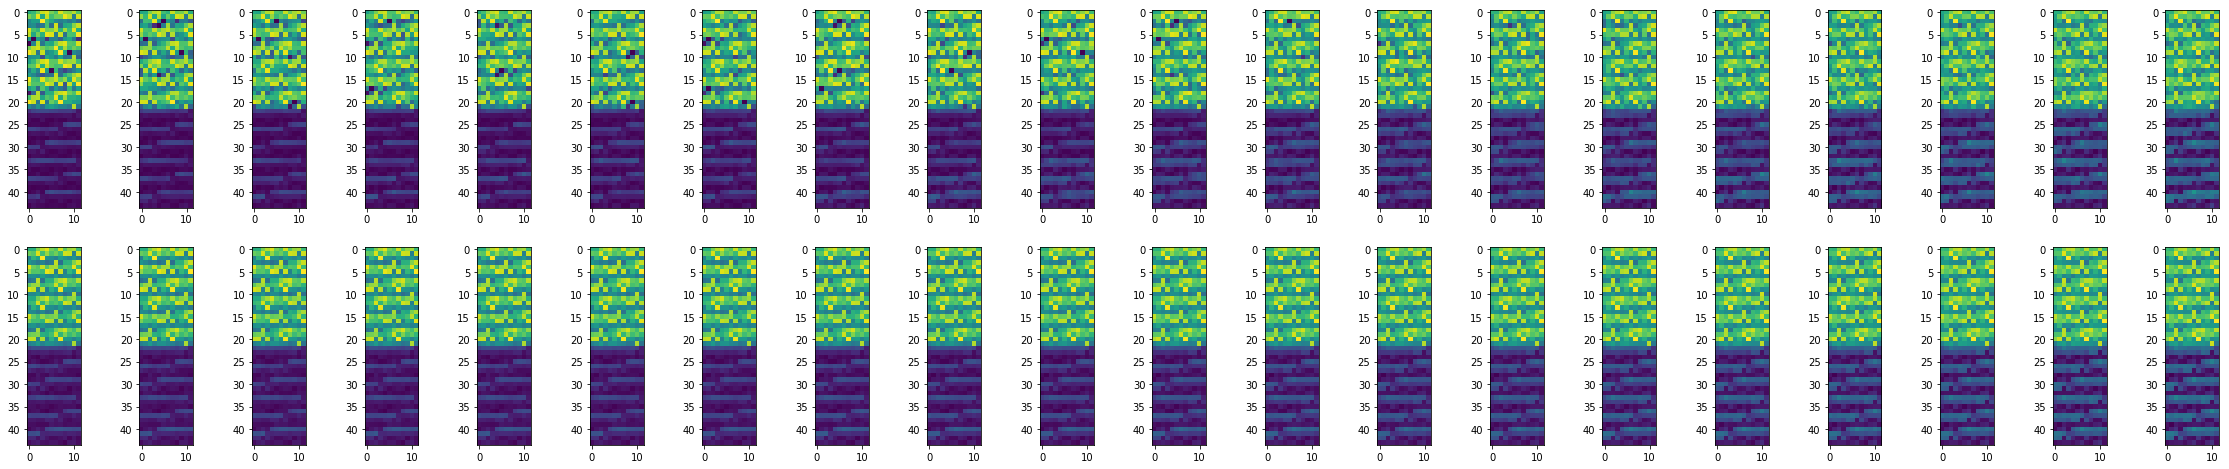

In [14]:
decoded_images = autoencoder.predict(x)

print(decoded_images.shape, x.shape)
N, n_i = x.shape
x1 = x.reshape(N, 44, -1)
decoded_images = decoded_images.reshape(N, 44, -1)

n = 20
plt.figure(figsize=(40,8))
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x1[i])
    
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(decoded_images[i])
    
plt.show()

In [15]:
autoencoder.load_weights(save_dir + '/ae_weights.h5')

In [16]:
class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.

    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: degrees of freedom parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape = (self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
         Measure the similarity between embedded point z_i and centroid µ_j.
                 q_ij = 1/(1+dist(x_i, µ_j)^2), then normalize it.
                 q_ij can be interpreted as the probability of assigning sample i to cluster j.
                 (i.e., a soft assignment)
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) # Make sure each sample's 10 values add up to 1.
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [17]:
clustering_layer = ClusteringLayer(n_clusters, name ='clustering')(encoder.output)
model = Model(inputs=encoder.input, outputs=clustering_layer)
model.compile(optimizer=SGD(0.01, 0.9), loss='kld')
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(x))
y_pred_last = np.copy(y_pred)
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

# computing an auxiliary target distribution
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

loss = 0
index = 0
maxiter = 20000
update_interval = 140
index_array = np.arange(x.shape[0])
tol = 0.001 # tolerance threshold to stop training

Instructions for updating:
keep_dims is deprecated, use keepdims instead




In [18]:
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q = model.predict(x, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p

        # evaluate the clustering performance
        y_pred = q.argmax(1)
        if y is not None:
            acc = np.round(metrics.acc(y, y_pred), 5)
            nmi = np.round(metrics.nmi(y, y_pred), 5)
            ari = np.round(metrics.ari(y, y_pred), 5)
            loss = np.round(loss, 5)
            print('Iter %d: acc = %.5f, nmi = %.5f, ari = %.5f' % (ite, acc, nmi, ari), ' ; loss=', loss)

        # check stop criterion - model convergence
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
    loss = model.train_on_batch(x=x[idx], y=p[idx])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

model.save_weights(save_dir + '/DEC_model_final.h5')

Iter 0: acc = 0.06458, nmi = 0.44154, ari = 0.04071  ; loss= 0
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Iter 140: acc = 0.06548, nmi = 0.45530, ari = 0.04651  ; loss= 0.05747
Iter 280: acc = 0.06369, nmi = 0.42533, ari = 0.04101  ; loss= 0.13855
Iter 420: acc = 0.06548, nmi = 0.45104, ari = 0.04800  ; loss= 0.17151
Iter 560: acc = 0.06518, nmi = 0.45129, ari = 0.05023  ; loss= 0.11797
Iter 700: acc = 0.06518, nmi = 0.45312, ari = 0.05053  ; loss= 0.18142
Iter 840: acc = 0.06458, nmi = 0.45409, ari = 0.05132  ; loss= 0.16873
Iter 980: acc = 0.06399, nmi = 0.45557, ari = 0.05101  ; loss= 0.1981
Iter 1120: acc = 0.06339, nmi = 0.45317, ari = 0.05129  ; loss= 0.17363
Iter 1260: acc = 0.06339, nmi = 0.45114, ari = 0.05064  ; loss= 0.15847
Iter 1400: acc = 0.06518, nmi = 0.45939, ari = 0.05202  ; loss= 0.29636
Iter 1540: acc = 0.06369, nmi = 0.46255, ari = 0.05256  ; loss= 0.28669
Iter 1680: acc = 0.06339, nmi = 0.46415, ari = 0.05203  ; l

Iter 15400: acc = 0.06310, nmi = 0.43278, ari = 0.05025  ; loss= 0.38219
Iter 15540: acc = 0.06250, nmi = 0.43665, ari = 0.05095  ; loss= 0.08741
Iter 15680: acc = 0.06250, nmi = 0.43686, ari = 0.05141  ; loss= 0.09725
Iter 15820: acc = 0.06280, nmi = 0.43781, ari = 0.05114  ; loss= 0.06589
Iter 15960: acc = 0.06250, nmi = 0.43458, ari = 0.05065  ; loss= 0.07009
Iter 16100: acc = 0.06220, nmi = 0.43329, ari = 0.04973  ; loss= 0.05565
Iter 16240: acc = 0.06250, nmi = 0.43397, ari = 0.05019  ; loss= 0.09886
Iter 16380: acc = 0.06250, nmi = 0.43604, ari = 0.05054  ; loss= 0.05236
Iter 16520: acc = 0.06280, nmi = 0.43334, ari = 0.05019  ; loss= 0.11659
Iter 16660: acc = 0.06399, nmi = 0.44085, ari = 0.05171  ; loss= 0.10354
Iter 16800: acc = 0.06339, nmi = 0.43602, ari = 0.05106  ; loss= 0.15886
Iter 16940: acc = 0.06369, nmi = 0.43677, ari = 0.05123  ; loss= 0.08471
Iter 17080: acc = 0.06518, nmi = 0.44205, ari = 0.05130  ; loss= 0.09786
Iter 17220: acc = 0.06548, nmi = 0.44426, ari = 0.0

In [19]:
model.load_weights(save_dir + '/DEC_model_final.h5')

In [20]:
# Eval.
############ redefine test data set ##############

test = np.loadtxt("C:/Users/KOTI/project/AI_traffic_management/Deep Clustering/DenseLayer/data/test_speedflow8_normalized.csv", skiprows=1, delimiter=',', dtype=float)
x = test[:, 3:531].reshape([len(trains), 528])

y_year = test[:, 0].reshape([len(test)])
y_weekday = test[:, 1].reshape([len(test)])
y = test[:, 2].reshape([len(test)])

x = x.reshape((x.shape[0], -1))
#x = np.divide(x, 255.)    #normalized 데이터에서는 삭제


q = model.predict(x, verbose=0)
p = target_distribution(q)  # update the auxiliary target distribution p

# evaluate the clustering performance
y_pred = q.argmax(1)
if y is not None:
    acc = np.round(metrics.acc(y, y_pred), 5)
    nmi = np.round(metrics.nmi(y, y_pred), 5)
    ari = np.round(metrics.ari(y, y_pred), 5)
    loss = np.round(loss, 5)
    print('Acc = %.5f, nmi = %.5f, ari = %.5f' % (acc, nmi, ari), ' ; loss=', loss)

Acc = 0.06369, nmi = 0.44113, ari = 0.05190  ; loss= 0.1065


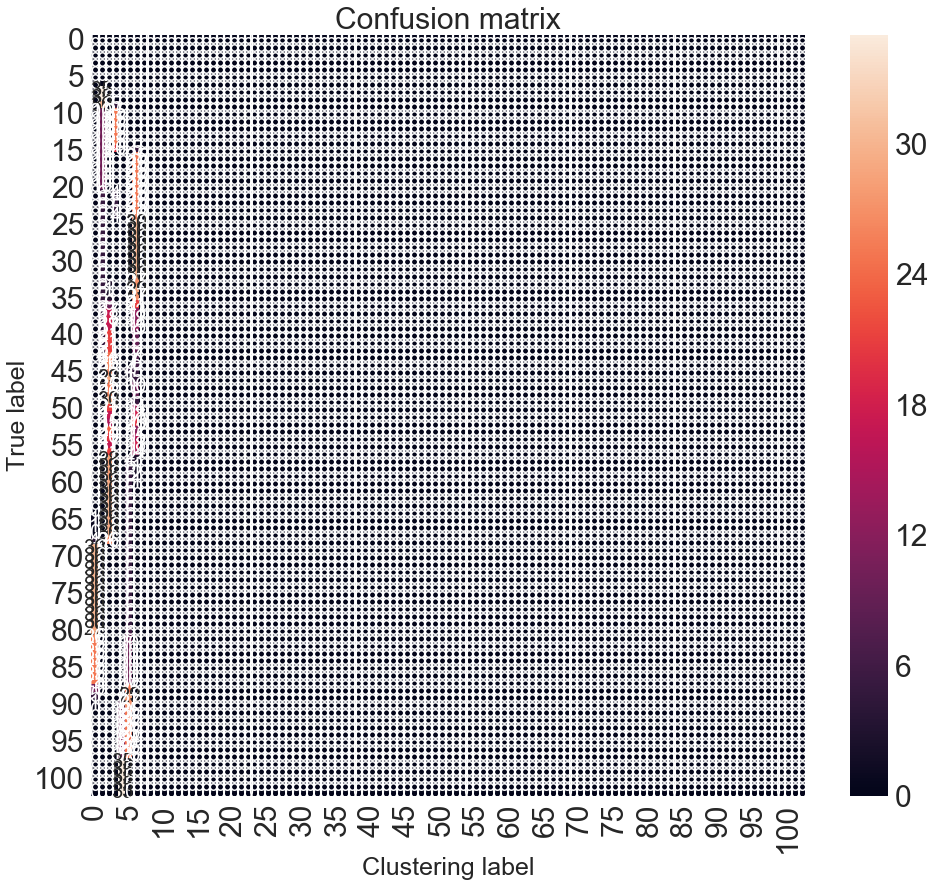

In [21]:
import seaborn as sns
import sklearn.metrics
import matplotlib.pyplot as plt
sns.set(font_scale=3)
confusion_matrix = sklearn.metrics.confusion_matrix(y, y_pred)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=30)
plt.ylabel('True label', fontsize=25)
plt.xlabel('Clustering label', fontsize=25)
plt.show()

In [22]:
from sklearn.utils.linear_assignment_ import linear_assignment

y_true = y.astype(np.int64)
D = max(y_pred.max(), y_true.max()) + 1
w = np.zeros((D, D), dtype=np.int64)
# Confusion matrix.
for i in range(y_pred.size):
    w[y_pred[i], y_true[i]] += 1
ind = linear_assignment(-w)

sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

0.06369047619047619

In [23]:
y_pred = y_pred.reshape(-1, 1)
y = y.reshape(-1, 1)

df = pd.DataFrame(y_year, columns = ['year'])
df['weekday'] = y_weekday
df['true'] = y
df['cluster_id'] = y_pred
df.to_excel('C:/Users/KOTI/project/AI_traffic_management/Deep Clustering/DenseLayer/results/test.xlsx', index = False )